In [2]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model


from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

In [4]:
img_width=256; img_height=256
batch_size=8
TRAINING_DIR = '../weather_pred/Data/training/'
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True
                                   )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))

Found 1274 images belonging to 5 classes.


In [5]:
VALIDATION_DIR = '../weather_pred/Data/validation/'

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )

Found 226 images belonging to 5 classes.


In [6]:
callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')        
# autosave best Model
best_model_file = '../efficientnet_drop_batch_best_weights_256.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True) 


In [11]:
efficientnet_base = EfficientNetB0(include_top=False, weights='imagenet',
                           input_tensor=None, input_shape=(img_height, img_width,3))

In [12]:
print('Adding new layers...')
output = efficientnet_base.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(512,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
# and a logistic layer -- let's say we have 4 classes
output = Dense(5, activation='softmax')(output)
print('New layers added!')

Adding new layers...
New layers added!


In [14]:
efficientnet_model = Model(efficientnet_base.input, output)
for layer in efficientnet_model.layers[:-7]:
    layer.trainable = False

efficientnet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 257, 257, 3)  0           ['normalization[0][0]']    

 block2a_project_bn (BatchNorma  (None, 64, 64, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 64, 64, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 64, 64, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 64, 64, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block3b_expand_activation (Act  (None, 32, 32, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 32, 32, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 32, 32, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_a

 block4b_bn (BatchNormalization  (None, 16, 16, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 16, 16, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
          

                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_s

 block5c_se_excite (Multiply)   (None, 16, 16, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 16, 16, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 16, 16, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 16, 16, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_a

                                                                                                  
 block6b_drop (Dropout)         (None, 8, 8, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 8, 8, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 8, 8, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 8, 8, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 8, 8, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 8, 8, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 8, 8, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 8, 8, 1152)  10368       ['block7a_expand_activation[0][0]
 D)       

In [15]:
efficientnet_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])
history = efficientnet_model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [callbacks, best_model]
                              )

C:\Users\Kerillos\AppData\Local\Temp\ipykernel_20624\3622504179.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = efficientnet_model.fit_generator(train_generator,


Epoch 1/30
160/160 [==============================] - 45s 240ms/step - loss: 0.9753 - accuracy: 0.6774 - val_loss: 0.4343 - val_accuracy: 0.9071
Epoch 2/30
160/160 [==============================] - 18s 110ms/step - loss: 0.6280 - accuracy: 0.8022 - val_loss: 0.3603 - val_accuracy: 0.8717
Epoch 3/30
160/160 [==============================] - 18s 110ms/step - loss: 0.4859 - accuracy: 0.8493 - val_loss: 0.2992 - val_accuracy: 0.9115
Epoch 4/30
160/160 [==============================] - 18s 112ms/step - loss: 0.3699 - accuracy: 0.8768 - val_loss: 0.2581 - val_accuracy: 0.9159
Epoch 5/30
160/160 [==============================] - 18s 111ms/step - loss: 0.3389 - accuracy: 0.8940 - val_loss: 0.3037 - val_accuracy: 0.9115
Epoch 6/30
160/160 [==============================] - 18s 110ms/step - loss: 0.3905 - accuracy: 0.8689 - val_loss: 0.2681 - val_accuracy: 0.9336
Epoch 7/30
160/160 [==============================] - 18s 109ms/step - loss: 0.2425 - accuracy: 0.9160 - val_loss: 0.2381 - val_ac

In [16]:
target_dir = '../weather_pred/' 
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
Inceptionv3_model.save(target_dir + 'efficientnet_model_256.h5')
Inceptionv3_model.save_weights(target_dir + 'efficientnet_weights_256.h5')

In [17]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

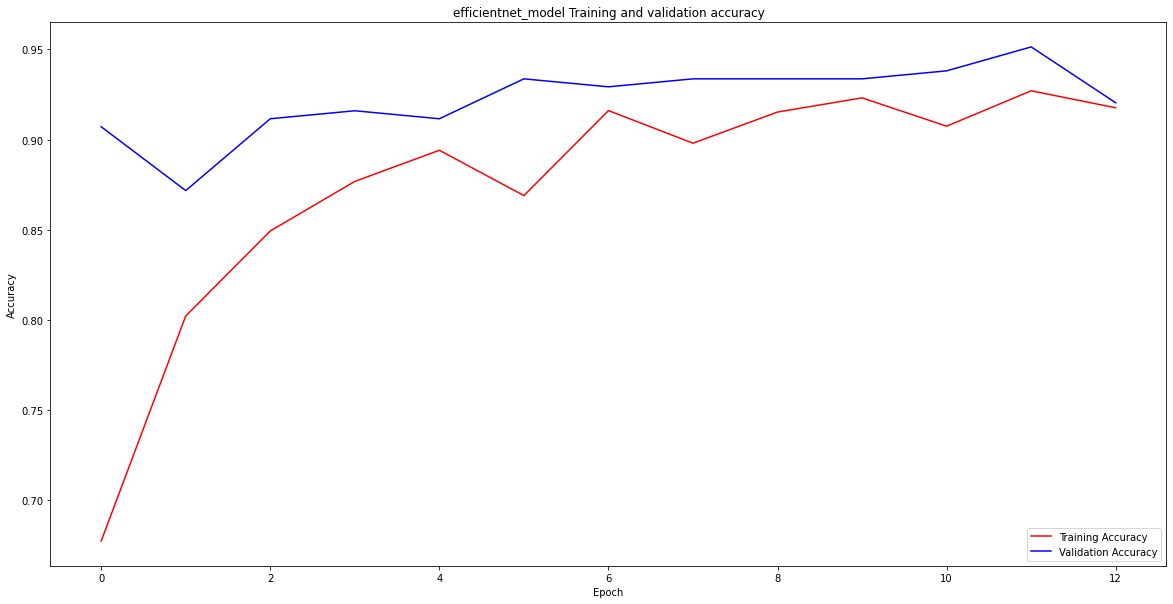

In [18]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('efficientnet_model Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig('Accuracy_curve_efficientnet_model.jpg')

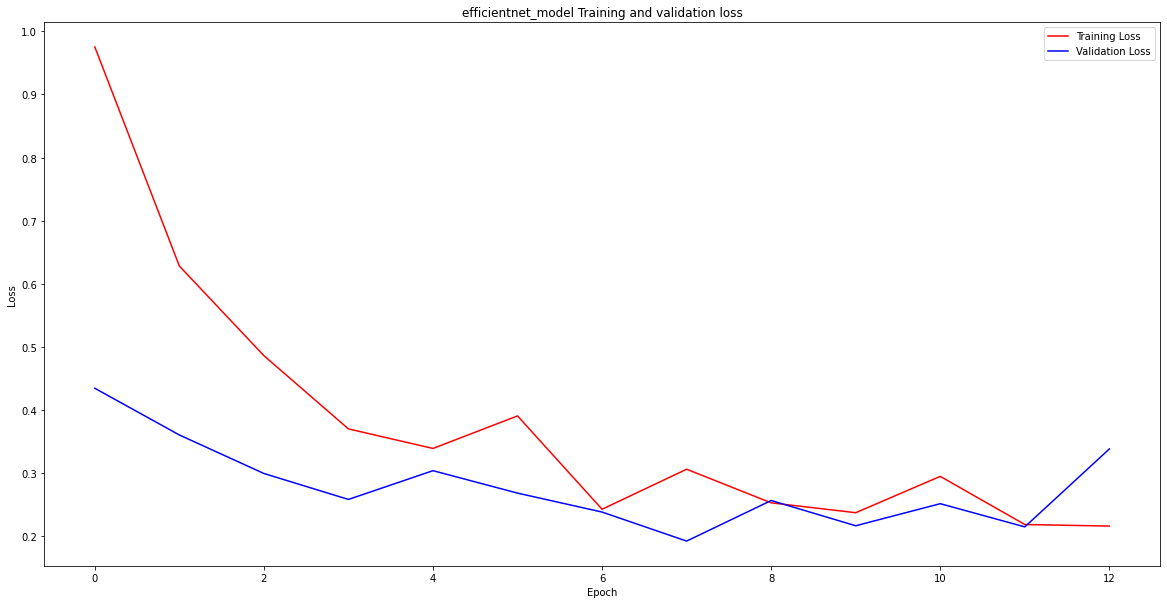

In [19]:
fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('efficientnet_model Training and validation loss')
fig2.savefig('Loss_curve_efficientnet_model.jpg')

In [20]:
import numpy as np
test_preprocessed_images = np.load('../test_preproc_res-net.npy')


In [21]:
#Prediction Function
array = efficientnet_model.predict(test_preprocessed_images, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)

30/30 [==============================] - 2s 12ms/step


In [22]:
import pandas as pd
test_df = pd.read_csv('../dataset/test.csv')
y_true = test_df['labels']

In [23]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, y_pred)


In [24]:
train_dir = '../weather_pred/Data/training/'
classes = os.listdir(train_dir)

In [25]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        
    else:
        cm=cm
        
    

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

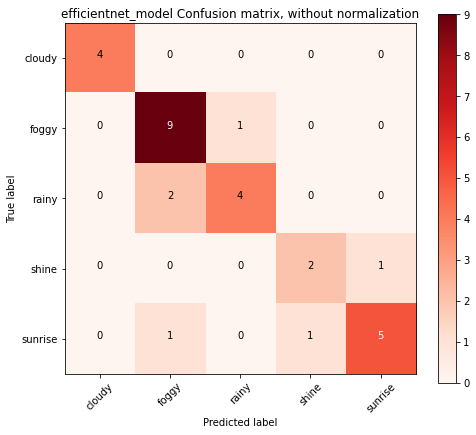

In [28]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='efficientnet_model Confusion matrix, without normalization')
plt.show()

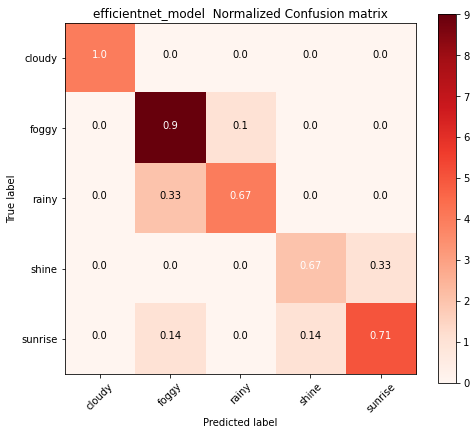

In [29]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='efficientnet_model  Normalized Confusion matrix')
fig2.savefig('../cm_norm.jpg')
plt.show()

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))


              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00         4
       foggy       0.75      0.90      0.82        10
       rainy       0.80      0.67      0.73         6
       shine       0.67      0.67      0.67         3
     sunrise       0.83      0.71      0.77         7

    accuracy                           0.80        30
   macro avg       0.81      0.79      0.80        30
weighted avg       0.80      0.80      0.80        30



In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.8